<a href="https://colab.research.google.com/github/Tom123454321876/AI-Projects/blob/main/AAI_521_04_FINAL_PROJECT_GROUP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Waste Classification with Convolutional Neural Networks - AAI 521  


> Team: Alexander Padin, Daniel Sims, Hassan Ali, Thomas Geraci

This project builds a computer vision system that automatically classifies common household waste into categories such as cardboard, glass, metal, paper, plastic, and trash. Using the TrashNet dataset and TensorFlow, we develop three models: a baseline convolutional neural network built from scratch and a two transfer-learning model using a pre-trained architecture like MobileNetV2 and EfficientNetB0. The project includes exploratory data analysis, preprocessing, training, evaluation, and comparison of the models using accuracy, confusion matrices, and class-level metrics.

### Dataset
The TrashNet dataset contains roughly 2,500 RGB images of common waste items collected using consumer-grade cameras or smartphones. Each image belongs to one of six labeled classes (cardboard, glass, metal, paper, plastic, or trash)and typically shows a single object against a simple background. Images vary naturally in lighting, orientation, and appearance, making the dataset realistic but still manageable for training convolutional neural networks. All images are provided in JPEG format at a resolution of 512x384 pixels, and we apply our own resizing, normalization, and augmentation during preprocessing. The dataset is widely used in academic demos and research on intelligent waste-sorting systems.

**Link:** [TrashNet Waste Image Dataset (Kaggle)](https://www.kaggle.com/datasets/feyzazkefe/trashnet)

### Imports

In [1]:
import os
import random
import numpy as np
import cv2
import requests
from pathlib import Path
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import PIL.Image as Image
from collections import Counter
import base64
from google.colab import output
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from IPython.display import Javascript, display
from io import BytesIO
import ipywidgets as widgets


# setting seed
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)
tf.keras.utils.set_random_seed(GLOBAL_SEED)

from google.colab import userdata  # Colab secrets API

KAGGLE_USERNAME = "thomasgeraci"
KAGGLE_KEY = "KGAT_9c161125dbd2553f6d57e14270cf927"

## Load Dataset
In this section we connect Colab to Kaggle, download the TrashNet dataset, and unzip it into the proper directory.

In [2]:
# Download TrashNet dataset form Kaggle

url = "https://www.kaggle.com/api/v1/datasets/download/feyzazkefe/trashnet"

# this requires authentication with Kaggle API keys
headers = {
    "Authorization": f"Kaggle {KAGGLE_USERNAME}:{KAGGLE_KEY}"
}

zip_path = "/content/trashnet.zip" # compressed download path

# download dataset
with requests.get(url, headers=headers, stream=True) as r:
    r.raise_for_status()
    with open(zip_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
print("Downloaded to:", zip_path)

extract_dir = "/content/trashnet" # extracted folder path
Path(extract_dir).mkdir(parents=True, exist_ok=True)

# unzip
with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(extract_dir)
print("Extracted to:", extract_dir)

Downloaded to: /content/trashnet.zip
Extracted to: /content/trashnet


## Exploratory Data Analysis (EDA)
This section performs quick EDA on the TrashNet images to confirm the dataset's structure and quality. We set DATA_DIR to the resized dataset, collect class folders, and extract class names to verify the labels. We inspect the folder structure, then show the first few images from each class in a grid to visually confirm the categories. We also compute image counts per class and plot them to check for imbalance. Finally, we scan all .jpg files to collect image sizes and confirm that every image is 512x384, which means a consistent resize strategy is safe.

### Verify Labels

In [3]:
DATA_DIR = Path("/content/trashnet/dataset-resized")

class_dirs = sorted([p for p in DATA_DIR.iterdir() if p.is_dir()])
class_names = [p.name for p in class_dirs]
print("Classes:", class_names)

Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [4]:
# Get count per class

for c in sorted(DATA_DIR.glob("*")): # for each folder (label)
    if c.is_dir(): # count .jpg files
        print(c.name, len(list(c.glob("*.jpg"))))

cardboard 403
glass 501
metal 410
paper 594
plastic 482
trash 137


### Verify Image Sizes

In [5]:
# Check image sizes

sizes = []

for c in DATA_DIR.glob("*"): # for each class
    for f in c.glob("*.jpg"): # for each .jpg
        img = Image.open(f) # open image
        sizes.append(img.size) # store its size (width, height)

# count each (width, height)
Counter(sizes)

Counter({(512, 384): 2527})

### Explore Images and Labels

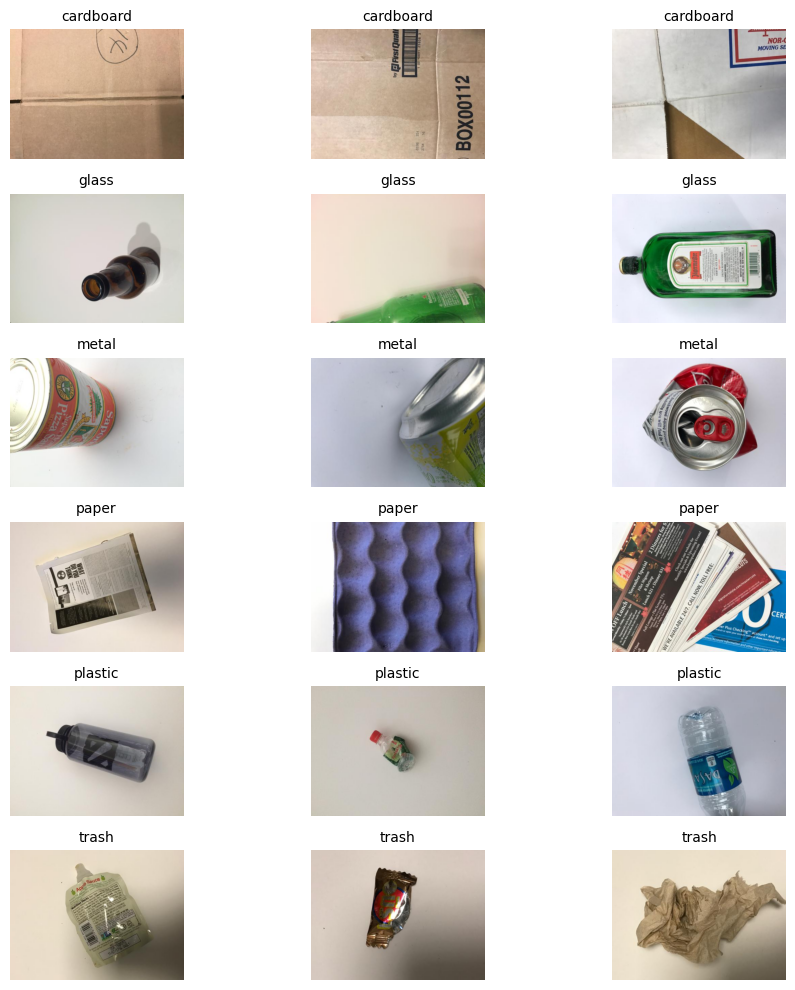

In [6]:
N = 3  # show first 3 images per class

plt.figure(figsize=(10, 10))

for row, class_dir in enumerate(class_dirs): # for each class
    image_paths = sorted(class_dir.glob("*.jpg")) # get all .jpg files for this class sorted by name
    sample_paths = image_paths[:N] # take the first N images

    for col, img_path in enumerate(sample_paths): # for each N image in the class
        idx = row * N + col + 1 # subplot index
        plt.subplot(len(class_names), N, idx)

        img = mpimg.imread(img_path) # read the image
        plt.imshow(img) # show the image
        plt.axis("off") # no ticks
        plt.title(class_dir.name, fontsize=10) # add class name

plt.tight_layout()
plt.show()

## Preprossesing
This section builds the TensorFlow input pipeline. We load the dataset using image_dataset_from_directory, resize images to 224x224, and use an 80/10/10 split by first creating a train/validation split and then splitting the validation set in half to form validation and test sets. We confirm the split by printing the number of batches in each dataset. Each dataset is wrapped with .prefetch(AUTOTUNE) to speed up training. Preprocessing is handled inside the model using a data-augmentation layer for the training set and normalization layers for all splits. Augmentation is applied only during training, while validation and test inputs are only normalized. By the end, we have clean, batched datasets and a preprocessing pipeline embedded in Keras layers.

### Split Datasets

In [7]:
# Split dataset 80% train, 10% validation, 10% test

img_size = (224, 224) # new size
batch_size = 32 # batch size

# training set
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred", # labels come from subfolder names
    label_mode="int", # integer labels
    validation_split=0.2, # 20% for validation/test
    subset="training", # return training subset
    seed=GLOBAL_SEED, # fixed seed for reproducibility
    image_size=img_size, # resize 512x384 to 224x224
    batch_size=batch_size # images per batch
)

# temp validation set
temp_val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="int",
    validation_split=0.2, # same split
    subset="validation", # return validation subset
    seed=GLOBAL_SEED,
    image_size=img_size,
    batch_size=batch_size
)

# split temp validation set into (50% validation/50% test)
val_size = tf.data.experimental.cardinality(temp_val_ds_raw) // 2
val_ds_raw = temp_val_ds_raw.take(val_size) # validation set
test_ds_raw = temp_val_ds_raw.skip(val_size) # test set

print("\nTrain batches:", tf.data.experimental.cardinality(train_ds_raw).numpy())
print("Val batches:", tf.data.experimental.cardinality(val_ds_raw).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds_raw).numpy())

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.

Train batches: 64
Val batches: 8
Test batches: 8


### Define Normalization and Augmentation Layers

In [8]:
# We decided to bake normalization and augmentation into Keras layers to keep training
# and deployment consistent and to make the model easier to share and reuse.

AUTOTUNE = tf.data.AUTOTUNE # for performance for TF

# data augmentation for training dataset only to simulate realistic variations in trash images
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"), # flips
        layers.RandomRotation(0.1), # small random rotations
        layers.RandomZoom(0.1), # small zoom in/out
        layers.RandomContrast(0.1), # change contrast slightly
    ],
    name="data_augmentation"
)

# Normalization
# CNN model preprocessing function [0, 255] -> [0, 1]
normalization_layer_cnn = layers.Rescaling(1.0 / 255.0, name="rescale")

# MobileNetV2-specific preprocessing function (scales to [-1, 1])
normalization_layer_mobilenet = tf.keras.applications.mobilenet_v2.preprocess_input

# EfficientNetB0-specific preprocessing function (scales to [-1, 1])
normalization_layer_efficientnet = tf.keras.applications.efficientnet.preprocess_input

## Modeling
This section builds and trains three models on the TrashNet dataset. First, we create a baseline CNN trained from scratch using 224x224 images, in-model augmentation, normalization, three Conv2D blocks, and a dense classification head. All models use the Adam optimizer with a learning rate of 1e-3, along with EarlyStopping and ReduceLROnPlateau callbacks. Next, we train a MobileNetV2 transfer-learning model by loading ImageNet weights, freezing the base, applying MobileNetV2 preprocessing, and adding a lightweight classification head. Finally, we train an EfficientNetB0 model with its own preprocessing and a frozen base. All three models use the same train/validation/test splits and consistent callback settings to ensure a fair comparison.

### Pre-fetching Datasets

In [9]:
# Prefetch datasets

# training
train_ds = (
    train_ds_raw
    .shuffle(1000, seed=GLOBAL_SEED, reshuffle_each_iteration=True) # add shuffle
    .prefetch(AUTOTUNE)
)

# validation and test
val_ds = val_ds_raw.prefetch(AUTOTUNE)
test_ds = test_ds_raw.prefetch(AUTOTUNE)

### Convolutional Neural Network (CNN)

In [10]:
# Simple CNN built from scratch for Trash classification.

def build_cnn_model(input_shape, num_classes):

  inputs = keras.Input(shape=input_shape, name="input_image") # (height, width, channels)

  x = data_augmentation(inputs) # data augmentation when training=True
  x = normalization_layer_cnn(x) # normalization [0, 255] to [0, 1]

  # convolutional feature extractor
  # 1st conv block: 32 filters, 3x3 kernel, ReLU activation, same padding
  x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x) # 1st layer: 32 neurons
  x = layers.MaxPooling2D((2, 2))(x)

  # 2nd conv block: 64 filters
  x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x) # 2nd layer: 64 neurons
  x = layers.MaxPooling2D((2, 2))(x)


  # 3rd conv block: 128 filters
  x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x) # 3rd layer: 128 neurons
  x = layers.MaxPooling2D((2, 2))(x)

  # classification head
  x = layers.Flatten()(x) # flatten 3D feature maps into a 1D vector
  x = layers.Dense(256, activation="relu")(x) # fully connected layer with 256 units
  x = layers.Dropout(0.5)(x) # 50% dropout

  outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x) # output classification layer

  model = keras.Model(inputs=inputs, outputs=outputs, name="trashnet_cnn_from_scratch")
  return model

In [11]:
# Build and compile

input_shape = (img_size[0], img_size[1], 3)  # (224, 224, 3)
num_classes = len(train_ds_raw.class_names) # number of classes

# build CNN model
cnn_model = build_cnn_model(input_shape, num_classes)

# compile CNN model
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), # learning rate 1e-3
    loss="sparse_categorical_crossentropy", # labels are integers (0..num_classes-1)
    metrics=["accuracy"],
)

cnn_model.summary()

Model: "trashnet_cnn_from_scratch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescale (Rescaling)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,785,158 (98.36 MB)

 Trainable params: 25,785,158 (98.36 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
epochs = 40 # number of epochs

# callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # stops training early if it doesn’t improve for 5 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5) # cuts the learning rate in half if it stops improving

# train the CNN model
history = cnn_model.fit(
    train_ds, # training dataset (augmented + normalized)
    validation_data=val_ds,  # validation dataset (only normalized)
    epochs=epochs,
    callbacks=[early_stop, reduce_lr], # callbacks
    verbose=1,
)

Epoch 1/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.2229 - loss: 2.2971 - val_accuracy: 0.3125 - val_loss: 1.5565 - learning_rate: 0.0010
Epoch 2/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.3855 - loss: 1.4917 - val_accuracy: 0.3984 - val_loss: 1.4301 - learning_rate: 0.0010
Epoch 3/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.4453 - loss: 1.3793 - val_accuracy: 0.4062 - val_loss: 1.3757 - learning_rate: 0.0010
Epoch 4/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.4712 - loss: 1.3503 - val_accuracy: 0.4883 - val_loss: 1.3863 - learning_rate: 0.0010
Epoch 5/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.5189 - loss: 1.2651 - val_accuracy: 0.5117 - val_loss: 1.2598 - learning_rate: 0.0010
Epoch 6/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.5093 - loss: 1.2212 - val_accuracy: 0.5703 - val_loss: 1.1281 - learning_rate: 0.0010
Epoch 7/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.5747 - loss: 1.1094 - val_ac

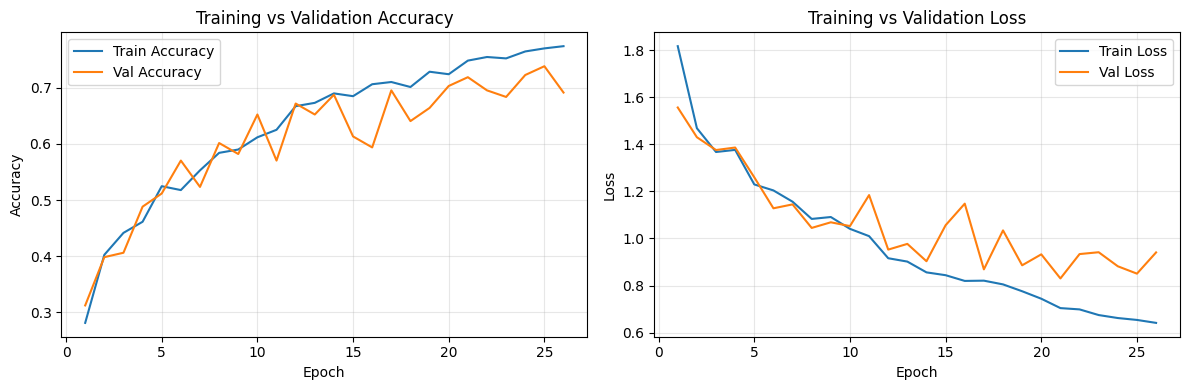

In [13]:
# Learning curve output for CNN

# extract metrics
train_acc = history.history["accuracy"] # training accuracy per epoch
val_acc = history.history["val_accuracy"] # validation accuracy per epoch
train_loss = history.history["loss"] # training loss per epoch
val_loss = history.history["val_loss"] # validation loss per epoch

epochs_range = range(1, len(train_acc) + 1)    # 1..N epochs

# plot accuracy and loss
plt.figure(figsize=(12, 4))

# accuracy curve
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# loss curve
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### MobileNetV2 (Transfer Learning)

In [14]:
# Transfer learning model with MobileNetV2

def build_mobilenet_model(input_shape, num_classes):
    # pre-trained base model
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet", # pre-trained on imagenet dataset (https://navigu.net/#imagenet#n03958227/n03958227_12842.jpg)
    )
    base_model.trainable = False  # freeze base

    inputs = keras.Input(shape=input_shape, name="input_image")

    x = inputs
    # data augmentation (only when training=True)
    x = data_augmentation(inputs)

    # preprocess for MobileNetV2 (scales/normalizes)
    x = normalization_layer_mobilenet(x)

    # feature extractor
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    # classification head
    outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="mobilenetv2_trashnet")
    return model

In [15]:
input_shape = (img_size[0], img_size[1], 3)   # (224, 224, 3)
num_classes = len(train_ds_raw.class_names)

mobilenet_model = build_mobilenet_model(input_shape, num_classes) # build

# compile
mobilenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

mobilenet_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "mobilenetv2_trashnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
epochs = 50

history_mobilenet = mobilenet_model.fit(
    train_ds_raw,
    validation_data=val_ds_raw,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr], # same callback as baseline CNN model
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.4103 - loss: 1.5506 - val_accuracy: 0.7109 - val_loss: 0.8191 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.7373 - loss: 0.7591 - val_accuracy: 0.7500 - val_loss: 0.6696 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.7605 - loss: 0.6309 - val_accuracy: 0.8242 - val_loss: 0.5309 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.7876 - loss: 0.5833 - val_accuracy: 0.8164 - val_loss: 0.4982 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.8092 - loss: 0.5310 - val_accuracy: 0.7891 - val_loss: 0.5695 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.8071 - loss: 0.4896 - val_accuracy: 0.8359 - val_loss: 0.5139 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.8381 - loss: 0.4259 - val_ac

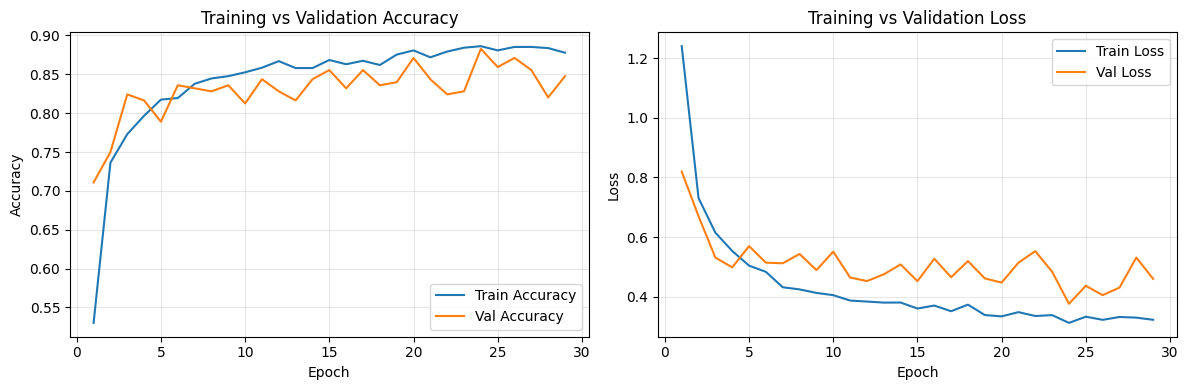

In [17]:
# Show learning curve for MobileNet model

# extract metrics
train_acc = history_mobilenet.history["accuracy"] # training accuracy per epoch
val_acc = history_mobilenet.history["val_accuracy"] # validation accuracy per epoch
train_loss = history_mobilenet.history["loss"] # training loss per epoch
val_loss = history_mobilenet.history["val_loss"] # validation loss per epoch

epochs_range = range(1, len(train_acc) + 1)    # 1..N epochs

# plot accuracy and loss
plt.figure(figsize=(12, 4))

# accuracy curve
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# loss curve
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### EfficientNetB0 (Transfer Learning)

In [18]:
# EfficientNetB0 transfer learning model

def build_efficientnetb0_model(input_shape, num_classes):
    # raw uint8 [0–255] images
    inputs = keras.Input(shape=input_shape, name="input_image")

    # data augmentation (only when training=True)
    x = data_augmentation(inputs)

    # preprocess for MobileNetV2 (scales/normalizes)
    x = normalization_layer_efficientnet(x)

    # EfficientNetB0 backbone
    base_model = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_tensor=x,  # pass augmented+normalized tensor
        name="efficientnetb0"
    )
    base_model.trainable = False  # freeze CNN

    # classification head
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="trashnet_efficientnetb0")

In [19]:
# Build and compile the model

input_shape = (img_size[0], img_size[1], 3)  # (224, 224, 3)
num_classes = len(train_ds_raw.class_names)

# build
effnet_model = build_efficientnetb0_model(input_shape, num_classes)

# compile
effnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

effnet_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "trashnet_efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_image[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 4,057,257 (15.48 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [20]:
epochs = 40  # num of epochs

history_effnet = effnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr],  # same callback as baseline CNN model
)

Epoch 1/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.4701 - loss: 1.3768 - val_accuracy: 0.7734 - val_loss: 0.6691 - learning_rate: 0.0010
Epoch 2/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.7891 - loss: 0.6508 - val_accuracy: 0.8242 - val_loss: 0.5517 - learning_rate: 0.0010
Epoch 3/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.8217 - loss: 0.5465 - val_accuracy: 0.8281 - val_loss: 0.4835 - learning_rate: 0.0010
Epoch 4/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.8629 - loss: 0.4399 - val_accuracy: 0.8594 - val_loss: 0.4195 - learning_rate: 0.0010
Epoch 5/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.8672 - loss: 0.4040 - val_accuracy: 0.8555 - val_loss: 0.4150 - learning_rate: 0.0010
Epoch 6/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.8778 - loss: 0.3911 - val_accuracy: 0.8477 - val_loss: 0.4367 - learning_rate: 0.0010
Epoch 7/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.8815 - loss: 0.3548 - val_a

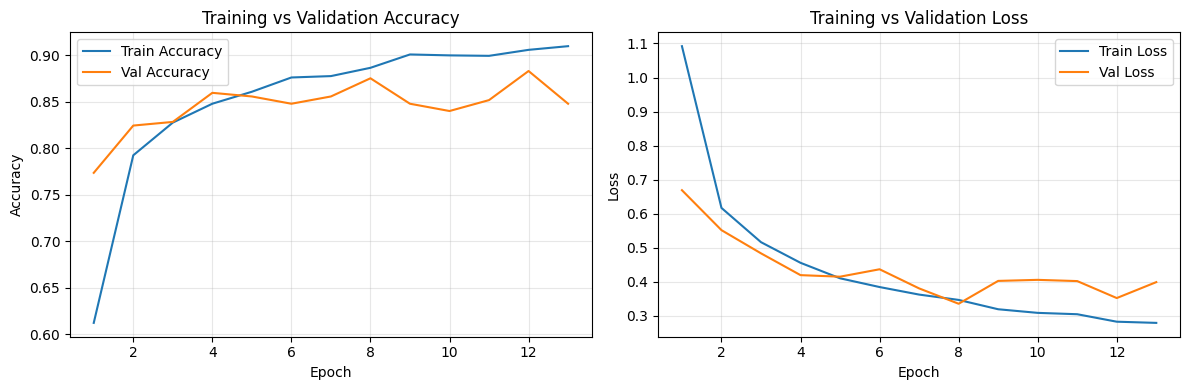

In [21]:
# Show learning curve for EfficientNetB0 model

# extract metrics
train_acc = history_effnet.history["accuracy"] # training accuracy per epoch
val_acc = history_effnet.history["val_accuracy"] # validation accuracy per epoch
train_loss = history_effnet.history["loss"] # training loss per epoch
val_loss = history_effnet.history["val_loss"] # validation loss per epoch

epochs_range = range(1, len(train_acc) + 1) # 1..N epochs

# plot accuracy and loss
plt.figure(figsize=(12, 4))

# accuracy curve
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# loss curve
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Validation and Performance Metrics
This section evaluates the trained models and compares their performance. We start by running model.evaluate(test_ds) for the CNN, MobileNetV2, and EfficientNetB0 to report test loss and accuracy for each. We then compute confusion matrices by collecting predictions across the test set and visualize them to see where each model struggles, such as confusing similar classes. We also generate classification reports that include precision, recall, and f1-scores for every class. Finally, we summarize which model performs best overall, how transfer learning compares to the from-scratch CNN, and any trade-offs we observed.

### Model Evaluation

In [22]:
test_loss, test_acc = cnn_model.evaluate(test_ds, verbose=0)
test_loss_mobilenet, test_acc_mobilenet = mobilenet_model.evaluate(test_ds, verbose=0)
test_loss_effnet, test_acc_effnet = effnet_model.evaluate(test_ds, verbose=0)

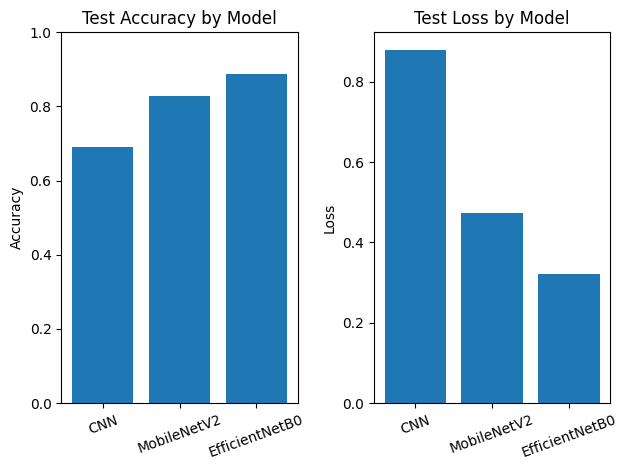

CNN: Test Acc (0.6908) Test Loss (0.8792)
MobileNetV2: Test Acc (0.8273) Test Loss (0.4722)
EfficientNetB0: Test Acc (0.8876) Test Loss (0.3212)


In [23]:
model_names = ["CNN", "MobileNetV2", "EfficientNetB0"]
test_accuracies = [test_acc, test_acc_mobilenet, test_acc_effnet]
test_losses = [test_loss, test_loss_mobilenet, test_loss_effnet]

x = np.arange(len(model_names))

plt.figure()

# accuracy bar chart
plt.subplot(1, 2, 1)
plt.bar(x, test_accuracies)
plt.xticks(x, model_names, rotation=20)
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title("Test Accuracy by Model")

# loss bar chart
plt.subplot(1, 2, 2)
plt.bar(x, test_losses)
plt.xticks(x, model_names, rotation=20)
plt.ylabel("Loss")
plt.title("Test Loss by Model")

plt.tight_layout()
plt.show()

# print
for name, acc, loss in zip(model_names, test_accuracies, test_losses):
    print(f"{name}: Test Acc ({acc:.4f}) Test Loss ({loss:.4f})")

### Confusion Matrices

In [24]:
# Classification matrices

def get_cm(model):
  y_true, y_pred = [], []

  for images_batch, labels_batch in test_ds: # for each test dataset batches
      probs = model.predict(images_batch, verbose=0) # (batch_size, num_classes)
      batch_preds = np.argmax(probs, axis=1) # predicted class indices

      # add labels and predictions to the lists
      y_true.extend(labels_batch.numpy())
      y_pred.extend(batch_preds)

  # convert lists to numpy arrays
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  # get confusion matrix
  return confusion_matrix(y_true, y_pred)

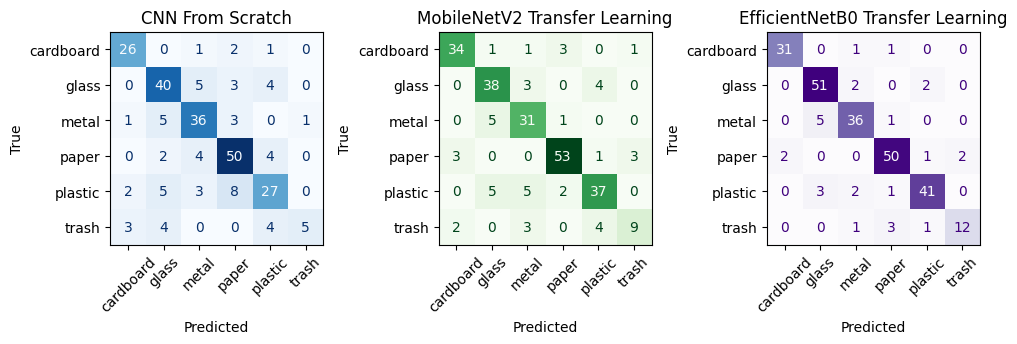

In [25]:
# Compute confusion matrices

cm_cnn = get_cm(cnn_model)
cm_mobilenet = get_cm(mobilenet_model)
cm_effnet = get_cm(effnet_model)

# create 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# CNN
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=class_names)
disp_cnn.plot(
    ax=axes[0],
    cmap="Blues",
    values_format="d",
    xticks_rotation=45,
    colorbar=False
)
axes[0].set_title("CNN From Scratch")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# MobileNetV2
disp_mobilenet = ConfusionMatrixDisplay(confusion_matrix=cm_mobilenet, display_labels=class_names)
disp_mobilenet.plot(
    ax=axes[1],
    cmap="Greens",
    values_format="d",
    xticks_rotation=45,
    colorbar=False
)
axes[1].set_title("MobileNetV2 Transfer Learning")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

# EfficientNetB0
disp_effnet = ConfusionMatrixDisplay(confusion_matrix=cm_effnet, display_labels=class_names)
disp_effnet.plot(
    ax=axes[2],
    cmap="Purples",
    values_format="d",
    xticks_rotation=45,
    colorbar=False
)
axes[2].set_title("EfficientNetB0 Transfer Learning")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("True")

plt.tight_layout()
plt.show()

## Modeling Results and Findings

The overall best performer is EfficientNetB0, which achieves the highest test accuracy and the lowest test loss. Its confusion matrix shows fewer misclassifications across most classes, especially for glass, paper, and metal. MobileNetV2 also performs well with a moderate test loss, and its errors are noticeably lower than the CNN's, confirming that transfer learning provides a meaningful boost. The CNN trained from scratch performs the worst and shows more cross-class confusion, which is expected given the limited size of TrashNet and the fact that it must learn features without pretrained knowledge.

The trade-offs are straightforward: the baseline CNN is simpler and trains quickly but underfits; MobileNetV2 is lightweight and accurate; EfficientNetB0 offers the strongest performance but is slightly heavier and takes longer to train. Overall, transfer learning clearly outperforms the from-scratch model on both accuracy and stability, with EfficientNetB0 providing the best balance of feature quality and generalization.

## Fine Tunning Selected Model
To further improve the performance of EfficientNetB0, our top model, we performed a targeted fine tuning stage. After training the model with its pretrained ImageNet weights frozen, we selectively unfroze deeper EfficientNet blocks while keeping earlier layers fixed. This allowed the network to adapt higher level feature representations specifically to TrashNet without disrupting the low level filters that were already well generalized. We also lowered the learning rate during fine tuning to avoid damaging the pretrained weights, kept the Adam optimizer at 0.001 for stability, and continued using EarlyStopping and ReduceLROnPlateau to control overfitting. This approach allowed EfficientNetB0 to learn more patterns specific to the dataset, especially for visually similar classes, which resulted in better generalization and the highest test accuracy among all models.

In [26]:
# Fine tuning selected Model

for layer in effnet_model.layers: # freeze all layers
    layer.trainable = False

# unfreeze the last N non-BatchNorm layers (e.g., last 50)
N = 50
for layer in effnet_model.layers[-N:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

# re-compile with a smaller learning rate
effnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# continue training
fine_tune_epochs = 20  # or 20, etc.
initial_epoch = len(history_effnet.history["loss"]) # starting from the last training

# train again, now with some EfficientNet layers unfrozen (fine-tuning phase)
history_effnet_ft = effnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epoch + fine_tune_epochs, # total epochs = previous + new
    initial_epoch=initial_epoch, # start counting from previous last epoch
    callbacks=[early_stop, reduce_lr],
)

Epoch 14/33
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.8911 - loss: 0.3270 - val_accuracy: 0.8828 - val_loss: 0.3492 - learning_rate: 1.0000e-05
Epoch 15/33
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.9059 - loss: 0.3029 - val_accuracy: 0.8945 - val_loss: 0.3060 - learning_rate: 1.0000e-05
Epoch 16/33
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.8934 - loss: 0.2982 - val_accuracy: 0.8867 - val_loss: 0.3372 - learning_rate: 1.0000e-05
Epoch 17/33
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.9070 - loss: 0.2794 - val_accuracy: 0.8555 - val_loss: 0.4082 - learning_rate: 1.0000e-05
Epoch 18/33
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.9203 - loss: 0.2455 - val_accuracy: 0.8711 - val_loss: 0.3631 - learning_rate: 1.0000e-05
Epoch 19/33
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9287 - loss: 0.2486 - val_accuracy: 0.8594 - val_loss: 0.3529 - learning_rate: 1.0000e-05
Epoch 20/33
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy

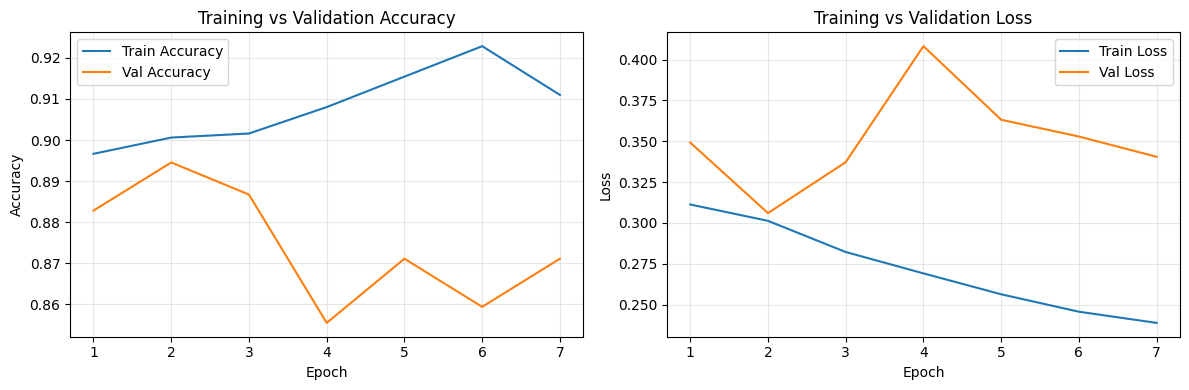

In [27]:
# Show learning curve for fine-tuned EfficientNetB0 model

# extract metrics
train_acc = history_effnet_ft.history["accuracy"] # training accuracy per epoch
val_acc = history_effnet_ft.history["val_accuracy"] # validation accuracy per epoch
train_loss = history_effnet_ft.history["loss"] # training loss per epoch
val_loss = history_effnet_ft.history["val_loss"] # validation loss per epoch

epochs_range = range(1, len(train_acc) + 1) # 1..N epochs

# plot accuracy and loss
plt.figure(figsize=(12, 4))

# accuracy curve
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# loss curve
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
test_loss_effnet, test_acc_effnet = effnet_model.evaluate(test_ds)
print(f"Fine-tuned EfficientNetB0 - Test accuracy: {test_acc_effnet:.4f}")
print(f"Fine-tuned EfficientNetB0 - Test loss: {test_loss_effnet:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8980 - loss: 0.3026
Fine-tuned EfficientNetB0 - Test accuracy: 0.8715
Fine-tuned EfficientNetB0 - Test loss: 0.3388


In [29]:
# Classification report for fine-tuned EfficientNetB0

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = effnet_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

   cardboard       0.90      0.97      0.94        38
       glass       0.96      0.87      0.91        52
       metal       0.82      0.98      0.89        46
       paper       0.92      0.96      0.94        51
     plastic       0.89      0.87      0.88        46
       trash       1.00      0.50      0.67        16

    accuracy                           0.90       249
   macro avg       0.92      0.86      0.87       249
weighted avg       0.91      0.90      0.90       249



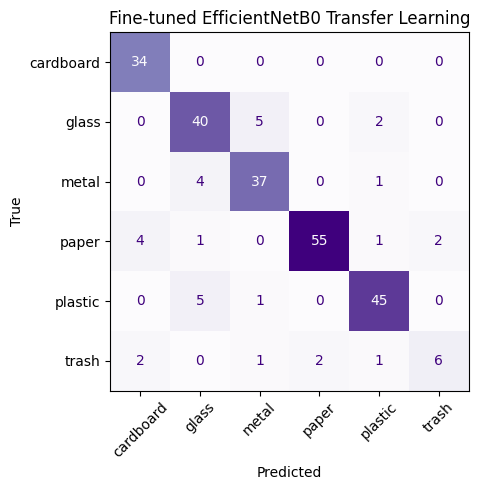

In [30]:
# Compute confusion matrix for fine-tuned EfficientNetB0

cm_effnet = get_cm(effnet_model)

# create a single subplot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# EfficientNetB0
disp_effnet = ConfusionMatrixDisplay(
    confusion_matrix=cm_effnet,
    display_labels=class_names
)
disp_effnet.plot(
    ax=ax,
    cmap="Purples",
    values_format="d",
    xticks_rotation=45,
    colorbar=False
)

ax.set_title("Fine-tuned EfficientNetB0 Transfer Learning")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

plt.tight_layout()
plt.show()

Fine-tuning EfficientNetB0 improved performance beyond the initial transfer-learning stage. The confusion matrix shows cleaner predictions across all classes, with fewer misclassifications. The training curves indicate steady improvement in training accuracy and decreasing training loss, while validation accuracy remains stable without signs of severe overfitting.

## Deploy
In the Deploy section, we turned our fine-tuned EfficientNetB0 model into a live webcam classifier running directly in Colab. Using the structure provided in Assignments 4 and 5, we adapted and expanded the code to fit our waste-classification task. The classify_effnet function processes a single frame by converting it from BGR to RGB, resizing it, running it through the model, applying softmax, and returning the top predicted label with its confidence. The detect_objects function overlays that prediction on each incoming frame using OpenCV. For real-time video, we reused and modified the JavaScript webcam pipeline from the previous assignments. capture_video()streams frames from the browser to Python, while the Python callback decodes each frame, runs EfficientNetB0 classification, draws the label, re-encodes the image, and updates a widgets.Image display. With these adaptations from earlier coursework, we created a working demo that performs real-time TrashNet classification on live webcam input.

In [31]:
# Classifier for a single frame

def classify_effnet(frame_bgr):

  img = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB) # to RGB
  img = cv2.resize(img, img_size)

  x = np.expand_dims(img, axis=0).astype("float32")

  preds = effnet_model.predict(x, verbose=0)[0] # logits or probs
  probs = tf.nn.softmax(preds).numpy() # to probabilities

  idx = int(np.argmax(probs))
  label = class_names[idx]
  conf = float(probs[idx])

  return label, conf

In [32]:
# Detect an object to classify

def detect_objects(frame_bgr):

  # get label and confidence
  label, conf = classify_effnet(frame_bgr)
  text = f"{label}: {conf*100:.1f}%"

  # add to frame
  cv2.putText(
    frame_bgr,
    text,
    (10, 30),
    cv2.FONT_HERSHEY_SIMPLEX,
    1.0,
    (0, 0, 0),
    2,
    cv2.LINE_AA
  )

  return frame_bgr

In [33]:
# JS to capture video: Used Assignment 5 implementation

def capture_video():
    display(Javascript('''
        async function captureVideo() {
            const video = document.createElement('video');
            const canvas = document.createElement('canvas');
            const context = canvas.getContext('2d');
            document.body.appendChild(video);
            video.style.display = 'none';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await new Promise((resolve) => video.onloadedmetadata = resolve);
            video.play();

            const [track] = stream.getVideoTracks();
            const settings = track.getSettings();
            canvas.width = settings.width;
            canvas.height = settings.height;

            async function stopVideo() {
                stream.getTracks().forEach(track => track.stop());
                video.remove();
                canvas.remove();
            }

            window.stopVideo = stopVideo;

            while (true) {
                context.drawImage(video, 0, 0, canvas.width, canvas.height);
                const imageData = canvas.toDataURL('image/jpeg', 0.8);
                const response = await google.colab.kernel.invokeFunction('notebook.getFrame', [imageData], {});
                if (response.data.result === 'quit') break;
                await new Promise((resolve) => setTimeout(resolve, 100));
            }

            stream.getTracks().forEach(track => track.stop());
            video.remove();
            canvas.remove();
        }
        captureVideo();
    '''))

In [34]:
# Python callback: get_frame

# store the last annotated frame so we can save it when stopping
last_frame_annotated = None

def get_frame(image_data):
  global last_frame_annotated
  try:
    image_data = image_data.split(",")[1]
    image_bytes = base64.b64decode(image_data)
    image = Image.open(BytesIO(image_bytes)) # PIL RGB
    frame = np.array(image) # RGB

    # convert to BGR for OpenCV
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    # run EfficientNet classification + overlay
    frame_annotated = detect_objects(frame_bgr)

    # keep a copy of the last annotated frame
    last_frame_annotated = frame_annotated.copy()

    # encode back to JPEG for the widget (expects BGR)
    _, img_encoded = cv2.imencode('.jpg', frame_annotated)
    image_widget.value = img_encoded.tobytes()

    return {'result': 'continue'}

  except Exception as e:
    print(f"Error processing frame: {e}")
    return {'result': 'error'}


In [36]:
output.register_callback('notebook.getFrame', get_frame)

image_widget = widgets.Image(format='jpeg')
display(image_widget)

def stop_video(change):
  eval_js('window.stopVideo()')
  return {'result': 'quit'}

stop_button = widgets.Button(description="Stop Video")
stop_button.on_click(stop_video)
display(stop_button)

capture_video() # deploy

Image(value=b'', format='jpeg')

Button(description='Stop Video', style=ButtonStyle())

<IPython.core.display.Javascript object>

## Conclusion
This project successfully implemented an end-to-end waste-classification system using deep learning and computer vision. Through systematic experimentation, we built three models (a baseline CNN, MobileNetV2, and EfficientNetB0) using consistent preprocessing and training settings to ensure a fair comparison. Transfer learning proved to be a major advantage: both pretrained models outperformed the CNN from scratch, with EfficientNetB0 achieving the strongest overall performance.

Fine-tuning EfficientNetB0 pushed the model even further, improving accuracy and reducing test loss by allowing deeper layers to adapt specifically to TrashNet's image distribution. The confusion matrices and classification reports confirmed better class separation and fewer misclassifications after fine-tuning.

Finally, we deployed the model in a real-time webcam demo. This created a functional prototype capable of detecting and labeling waste categories live, demonstrating how a research model can translate into an interactive application.